In [1]:
import time
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import random

import sys
sys.path.append('../')
from utils import IncConvModule
from utils import IncMaxPoolModule

### Theoretical and Eperical Speedups

In [30]:
batch_size = 128
in_channels = 64
in_size = 224
out_channels = in_channels
out_size = in_size
k_size = 3

conv = True

In [31]:
inc_conv_module = IncConvModule()
inc_max_pool_module = IncMaxPoolModule()

theoretical_speedup = []
emperical_speedup = []
best_achievable_speedup = []
cudnn_speedup = []

in_tensor = torch.FloatTensor(batch_size, in_channels,  in_size, in_size).random_(0, 10)
weights = torch.FloatTensor(out_channels, in_channels, k_size, k_size).random_(0, 10)
biases = torch.FloatTensor(out_channels).random_(0, 10)

in_tensor, weights, biases = in_tensor.cuda(), weights.cuda(), biases.cuda()

conv_module = torch.nn.Conv2d(in_channels, out_channels, k_size, padding=1, stride=1).cuda()
conv_module.weight.data = weights
conv_module.bias.data = biases
conv_module = torch.nn.Sequential(conv_module, torch.nn.ReLU(inplace=True))
max_pool_module = torch.nn.MaxPool2d(kernel_size=2, stride=2)

in_tensor, weights, biases = Variable(in_tensor), Variable(weights), Variable(biases)


#full inference
if conv:
    temp = conv_module(in_tensor)
else:
    temp = max_pool_module(in_tensor)
    
torch.cuda.synchronize()
prev_time = time.time()
for i in range(5):
    if conv:
        out_ptch = conv_module(in_tensor)
    else:
        out_ptch = max_pool_module(in_tensor)
    torch.cuda.synchronize()
torch.cuda.synchronize()
full_time = (time.time()-prev_time)/5/batch_size

x = range(1, in_size//4, k_size-1)
x_label = []

for p_size in x:
    
    #sanity check
    if p_size >= in_size:
        continue
    else:
        x_label.append(p_size)

    x_loc = random.sample(range(0, in_size-p_size), batch_size)
    y_loc = random.sample(range(0, in_size-p_size), batch_size)
    locations = zip(x_loc, y_loc)
    #locations = [(1,1), (1,5)]
    
    #patch size equvalient full inference
    in_tensor_prime = Variable(torch.FloatTensor(batch_size, in_channels,  p_size+(k_size-1), p_size+(k_size-1)).fill_(1.0).cuda())
    if conv:
        conv_module(in_tensor_prime)
    else:
        max_pool_module(in_tensor_prime)
        
    torch.cuda.synchronize()
    prev_time = time.time()
    for i in range(10):
        if conv:
            conv_module(in_tensor_prime)
        else:
            max_pool_module(in_tensor_prime)
        torch.cuda.synchronize()
    torch.cuda.synchronize()
    inc_best_time = (time.time()-prev_time)/10/batch_size
    
    #incremental inference
    patch_location_tensor = Variable(torch.from_numpy(np.array(locations, dtype=np.int32)).cuda())
    if conv:
        inc_conv_module(in_tensor, weights, biases, out_ptch, patch_location_tensor, 1, 1, k_size, p_height=p_size, p_width=p_size, version=4)
    else:
        inc_max_pool_module(in_tensor, out_ptch, patch_location_tensor,
                    0, 2, 2, p_height=p_size, p_width=p_size, version=1)
    torch.cuda.synchronize()
    prev_time = time.time()
    for i in range(10):
        patch_location_tensor = Variable(torch.from_numpy(np.array(locations, dtype=np.int32)).cuda())
        if conv:
            inc_conv_module(in_tensor, weights, biases, out_ptch, patch_location_tensor, 1, 1, k_size, p_height=p_size, p_width=p_size, version=4)
        else:
            inc_max_pool_module(in_tensor, out_ptch, patch_location_tensor,
                    0, 2, 2, p_height=p_size, p_width=p_size, version=1)

        torch.cuda.synchronize()
    torch.cuda.synchronize()
    empr_time = (time.time()-prev_time)/10/batch_size
    
    #_, output_size = inc_conv_module(in_tensor, weights, biases, out_ptch, patch_location_tensor, 1, 1, k_size, p_height=p_size, p_width=p_size, version=4)
    #print(output_size)
    
    theoretical_speedup.append(1.0*out_size*out_size/(p_size+k_size-1)**2)
    best_achievable_speedup.append(full_time/inc_best_time)
    emperical_speedup.append(full_time/empr_time)

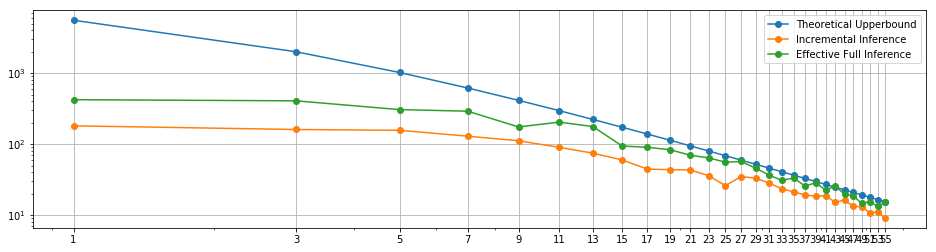

In [32]:
plt.rcParams["figure.figsize"] = (16,4)

plt.xscale('log')
plt.yscale('log')
plt.plot(x_label, theoretical_speedup, label='Theoretical Upperbound', marker='o')
plt.plot(x_label, emperical_speedup, label='Incremental Inference', marker='o')
plt.plot(x_label, best_achievable_speedup, label='Effective Full Inference', marker='o')
plt.xticks(x_label, x_label)
plt.legend()
plt.grid()
plt.show()

In [33]:
zip(x_label, theoretical_speedup, best_achievable_speedup, emperical_speedup)

[(1, 5575.111111111111, 423.53852544132917, 181.500355998576),
 (3, 2007.04, 408.27587587587584, 161.09787502962317),
 (5, 1024.0, 307.31434599156114, 156.89629173719032),
 (7, 619.4567901234568, 291.7090544986411, 129.72888040712468),
 (9, 414.6776859504132, 175.14067330814152, 111.77517127980268),
 (11, 296.89940828402365, 204.73225579761066, 90.46034421575585),
 (13, 223.00444444444443, 176.9951397326853, 74.662737057919),
 (15, 173.61937716262975, 94.39194630872483, 60.03350014718869),
 (17, 138.99168975069253, 90.44028560024834, 44.59031376407565),
 (19, 113.77777777777777, 83.68574828675776, 43.74009094028826),
 (21, 94.85066162570888, 69.92895106813427, 43.32656313072298),
 (23, 80.2816, 64.21089420654911, 36.05363835655187),
 (25, 68.82853223593965, 55.731799300393526, 26.0411941975687),
 (27, 59.66230677764566, 57.14192047969962, 35.002282752347114),
 (29, 52.21227887617066, 45.9734890326653, 33.273041719012575),
 (31, 46.0752984389348, 36.71175517551755, 28.38248065467906),
 

In [34]:
np.sum(np.abs((temp-out_ptch).cpu().data.numpy().flatten()))

0.0

In [7]:
#temp
#out_ptch
#temp-out_ptch
#patch_location_tensor